# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (Layer, Input, Conv2D, AveragePooling2D, Flatten, Dense, Concatenate,
                                     Rescaling, Embedding, BatchNormalization, Dropout, Add,
                                     LayerNormalization, MultiHeadAttention, Resizing, Permute)
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from datetime import datetime as dt

In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-24 09:33:17--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-24 09:33:17 (73.4 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_random_misclassified_images, plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Downloading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d niten19/face-shape-dataset
! unzip "/content/face-shape-dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: /content/dataset/FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: /content/data

# Data Loading

In [6]:
import shutil
from PIL import Image

In [7]:
base_dir = "/content"
data_path = os.path.join(base_dir, "dataset", "FaceShape Dataset", "training_set")
new_path = os.path.join(base_dir, "New_dataset", "Training_data")
os.makedirs(new_path, exist_ok=True)
class_list = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

# Define the desired image size
IMAGE_SIZE = (256, 256)

# Function to process and save an image
def process_and_save_image(image_path, destination_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
            img_format = img.format.lower()

        if img_format != 'jpeg':
            print(f"Skipping {image_path} as it is not a valid JPEG image.")
            return

        file_size = os.path.getsize(image_path)
        if file_size < 1000:
            print(f"Skipping {image_path} due to a small file size.")
            return

        test_image = cv2.imread(image_path)
        if test_image is not None:
            # Apply your image processing
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            # Save the processed image to the destination directory
            shutil.move(image_path, destination_path)
        else:
            print(f"Skipping {image_path} as it is a corrupt image.")
    except FileNotFoundError:
        print(f"File not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

# Iterate through the classes and process/save images
for class_name in os.listdir(data_path):
    if class_name in class_list:
        class_dir = os.path.join(data_path, class_name)
        new_class_dir = os.path.join(new_path, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        for file_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file_name)
            destination_path = os.path.join(new_class_dir, file_name)

            process_and_save_image(image_path, destination_path)

Skipping /content/dataset/FaceShape Dataset/training_set/Heart/heart (448).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Round/round (497).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Round/round (212).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Round/round (547).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Oval/oval (432).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Square/square (453).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/training_set/Oblong/oblong (724).jpg as it is not a valid JPEG image.


In [8]:
base_dir = "/content"
data_path = os.path.join(base_dir, "dataset", "FaceShape Dataset", "testing_set")
new_path = os.path.join(base_dir, "New_dataset", "Testing_data")
os.makedirs(new_path, exist_ok=True)
class_list = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

# Define the desired image size
IMAGE_SIZE = (256, 256)

# Function to process and save an image
def process_and_save_image(image_path, destination_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
            img_format = img.format.lower()

        if img_format != 'jpeg':
            print(f"Skipping {image_path} as it is not a valid JPEG image.")
            return

        file_size = os.path.getsize(image_path)
        if file_size < 1000:
            print(f"Skipping {image_path} due to a small file size.")
            return

        test_image = cv2.imread(image_path)
        if test_image is not None:
            # Apply your image processing
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            # Save the processed image to the destination directory
            shutil.move(image_path, destination_path)
        else:
            print(f"Skipping {image_path} as it is a corrupt image.")
    except FileNotFoundError:
        print(f"File not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

# Iterate through the classes and process/save images
for class_name in os.listdir(data_path):
    if class_name in class_list:
        class_dir = os.path.join(data_path, class_name)
        new_class_dir = os.path.join(new_path, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        for file_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file_name)
            destination_path = os.path.join(new_class_dir, file_name)

            process_and_save_image(image_path, destination_path)

Skipping /content/dataset/FaceShape Dataset/testing_set/Heart/heart (757).jpg as it is not a valid JPEG image.
Error processing /content/dataset/FaceShape Dataset/testing_set/Round/desktop.ini: cannot identify image file '/content/dataset/FaceShape Dataset/testing_set/Round/desktop.ini'
Skipping /content/dataset/FaceShape Dataset/testing_set/Oval/oval (528).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/testing_set/Square/square (465).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/testing_set/Oblong/oblong (697).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/testing_set/Oblong/oblong (316).jpg as it is not a valid JPEG image.
Skipping /content/dataset/FaceShape Dataset/testing_set/Oblong/oblong (702).jpg as it is not a valid JPEG image.


In [9]:
train_data_directory = "/content/New_dataset/Training_data"
test_data_directory = "/content/New_dataset/Testing_data"

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [58]:
train_dataset = image_dataset_from_directory(train_data_directory,
                                              labels = 'inferred',
                                              label_mode = 'categorical',
                                              color_mode = 'rgb',
                                              batch_size = 12,
                                              image_size = (256, 256),
                                              shuffle = True,
                                              seed = 99)

Found 3993 files belonging to 5 classes.


In [59]:
test_dataset = image_dataset_from_directory(test_data_directory,
                                            labels = 'inferred',
                                            label_mode = 'categorical',
                                            color_mode = 'rgb',
                                            batch_size = 12,
                                            image_size = (256, 256),
                                            shuffle = True,
                                            seed = 99)

Found 994 files belonging to 5 classes.


# Assigning Class Weights for imbalance data

In [13]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Total Number of Classes: ", num_classes)
print("Class Names:", class_names)

Total Number of Classes:  5
Class Names: ['Heart', 'Oblong', 'Oval', 'Round', 'Square']


In [14]:
# os.path.isdir: it will check the directory will exist or not
# os.path.isfile: this path refers to an existing path
subdirectories = [subdir for subdir in os.listdir(train_data_directory) if os.path.isdir(os.path.join(train_data_directory, subdir))]
subdirectories.sort()

image_counts = {}

for index, subdir in enumerate(subdirectories, start=0):
    subdirectory_path = os.path.join(train_data_directory, subdir)
    image_files = [filename for filename in os.listdir(subdirectory_path) if os.path.isfile(os.path.join(subdirectory_path, filename))]
    image_count = len(image_files)
    image_counts[index] = image_count

print("Image Count", image_counts)

Image Count {0: 799, 1: 799, 2: 799, 3: 797, 4: 799}


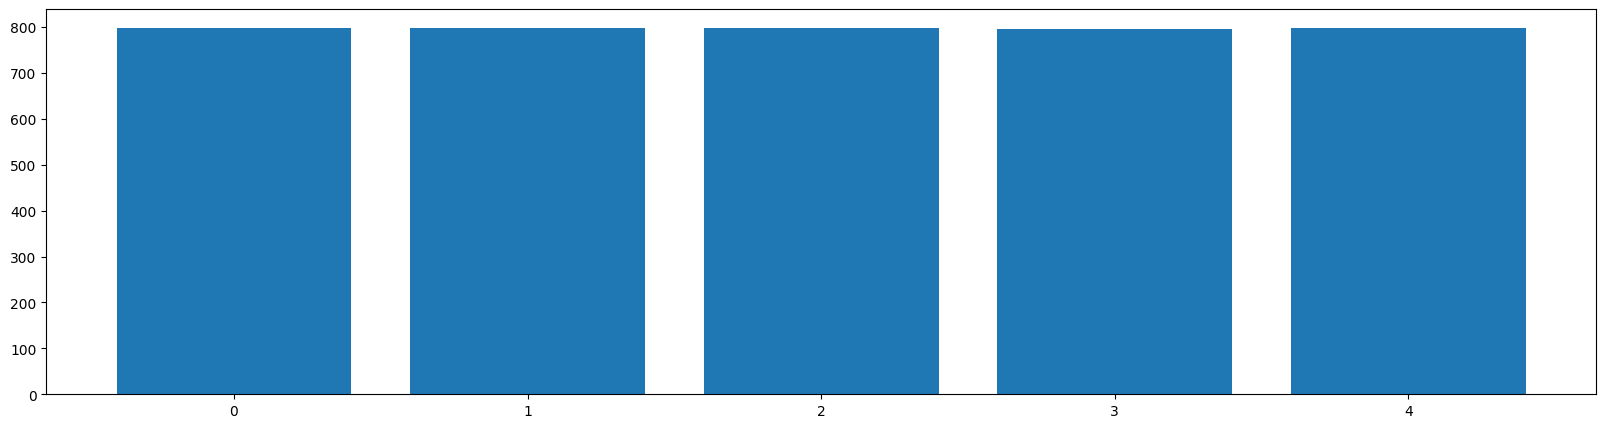

In [15]:
plt.figure(figsize=(20, 5))
image_index = list(image_counts.keys())
image_count = list(image_counts.values())

plt.bar(range(len(image_counts)), image_count, tick_label=image_index)
plt.show();

In [16]:
total_images_count = 4000
class_weights = {}
for index, count in image_counts.items():
  class_weights[index] = total_images_count / count

print("class Weights: ", class_weights)

class Weights:  {0: 5.006257822277847, 1: 5.006257822277847, 2: 5.006257822277847, 3: 5.018820577164367, 4: 5.006257822277847}


# Data Visulization

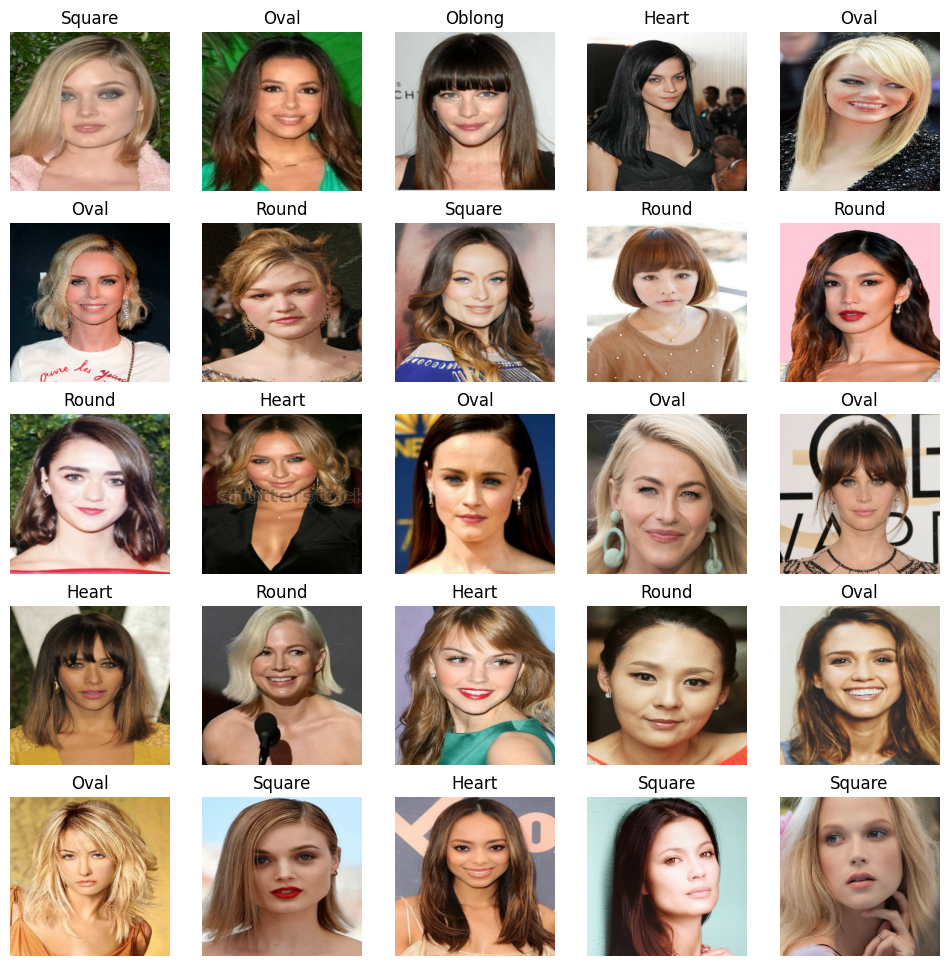

In [17]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1, xticks=[], yticks=[])
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off");

# Data Augumentation

In [18]:
data_augmentation = keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),])

In [19]:
aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

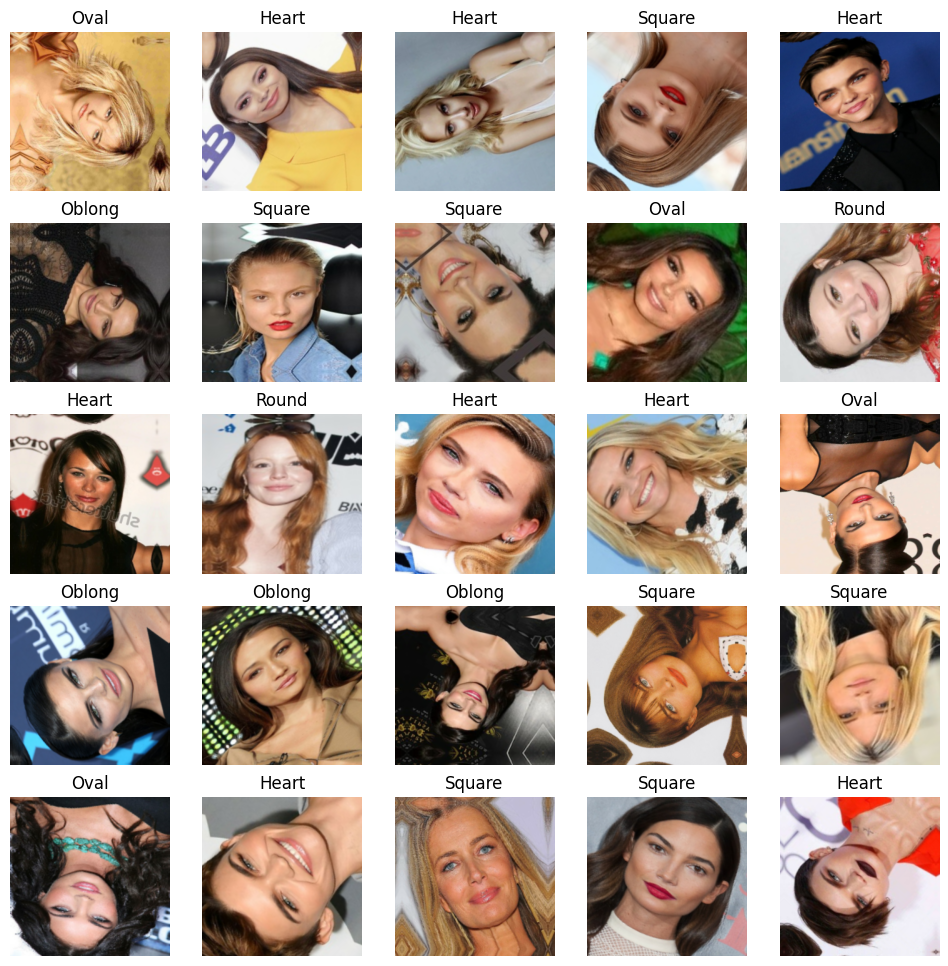

In [20]:
plt.figure(figsize=(12, 12))
for images, labels in aug_train_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1, xticks=[], yticks=[])
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off");

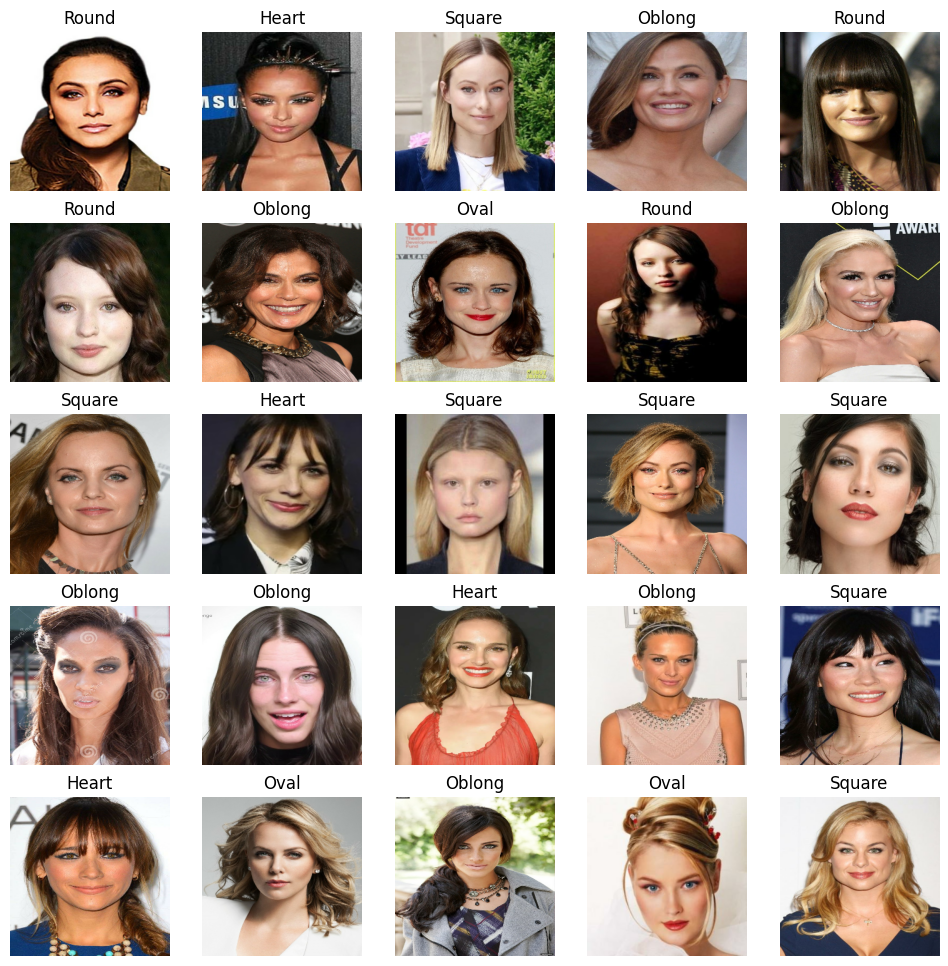

In [21]:
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1, xticks=[], yticks=[])
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off");

# Data Loading

In [22]:
train_dataset = (train_dataset
                .prefetch(tf.data.AUTOTUNE))

In [23]:
test_dataset = (test_dataset
                .prefetch(tf.data.AUTOTUNE))

# Paches Example

In [24]:
test_image = cv2.imread("/content/New_dataset/Testing_data/Heart/heart (101).jpg")
test_image = cv2.resize(test_image, (256, 256))

In [25]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                                    sizes=[1, 16, 16, 1],
                                    strides=[1, 16, 16, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID')

In [26]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], 256, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


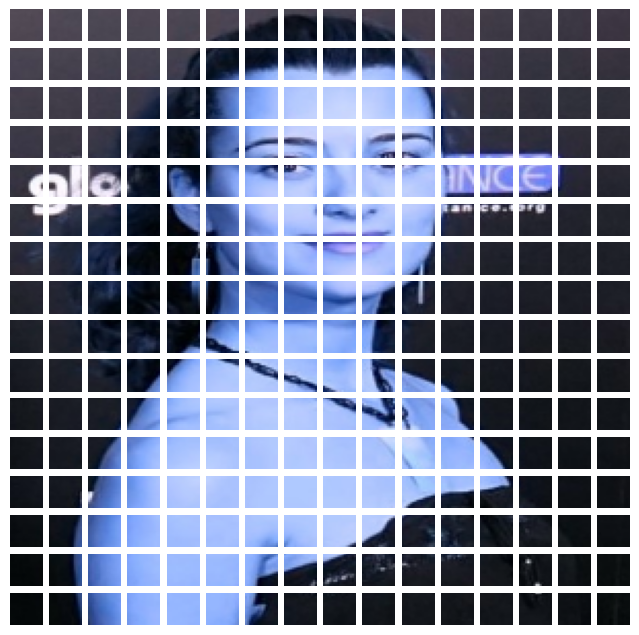

In [27]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):
  ax = plt.subplot(16,16, i+1)
  plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
  plt.axis("off")

# Vit model

In [28]:
@tf.keras.utils.register_keras_serializable()
class PatchEncoder(Layer):
  def __init__(self, n_patches, hidden_dim):
    super(PatchEncoder, self).__init__()
    self.n_patches = n_patches
    self.linear_projection = Dense(hidden_dim)
    self.positional_embeddings = Embedding(n_patches, hidden_dim)

  def call(self, x):
    patches = tf.image.extract_patches(images = x,
                                       sizes=[1, 16, 16, 1],
                                       strides=[1, 16, 16, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))  ## Correct this shape

    embedding_input = tf.range(start=0, limit=self.n_patches, delta=1)
    output = self.linear_projection(patches) + self.positional_embeddings(embedding_input)
    return output

  def get_config(self):
    config = super(PatchEncoder, self).get_config()
    config.update({
        'n_patches': self.n_patches,
        'linear_projection': self.linear_projection,
    })
    return config

In [29]:
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(Layer):
  def __init__(self, n_heads, hidden_size):
    super(TransformerEncoder, self).__init__()
    self.n_heads = n_heads
    self.hidden_size = hidden_size
    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    self.multi_head_attn = MultiHeadAttention(self.n_heads, self.hidden_size)
    self.dense_1 = Dense(self.hidden_size, activation=tf.nn.gelu)
    self.dense_2 = Dense(self.hidden_size, activation=tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_attn(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

  def get_config(self):
    config = super(TransformerEncoder, self).get_config()
    config.update({
        'n_heads': self.n_heads,
        'hidden_size': self.hidden_size,
    })
    return config

In [30]:
@tf.keras.utils.register_keras_serializable()
class Vit(Model):
  def __init__(self, n_heads, hidden_size, n_patches, n_layers, n_dense_units, num_classes):
    super(Vit, self).__init__()
    self.n_heads = n_heads
    self.hidden_size = hidden_size
    self.n_patches = n_patches
    self.n_layers = n_layers
    self.n_dense_units = n_dense_units
    self.num_classes = num_classes
    self.patch_encoder = PatchEncoder(self.n_patches, self.hidden_size)
    self.trans_encoders = [TransformerEncoder(self.n_heads, self.hidden_size) for _ in range(self.n_layers)]
    self.dense_1 = Dense(self.n_dense_units, activation=tf.nn.gelu)
    self.dense_2 = Dense(self.n_dense_units, activation=tf.nn.gelu)
    self.dense_3 = Dense(self.num_classes, activation='softmax')

  def call(self, input, training=True):
    x = self.patch_encoder(input)

    for i in range(self.n_layers):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

  def get_config(self):
    config = super(TransformerEncoder, self).get_config()
    config.update({
        'n_heads': self.n_heads,
        'hidden_size': self.hidden_size,
        'n_patches': self.n_patches,
        'n_layers': self.n_layers,
        'n_dense_units': self.n_dense_units,
        'num_classes': self.num_classes,
    })
    return config

In [31]:
n_heads = 4
hidden_size = 768
n_patches = 256
n_layers = 4
n_dense_units = 1024
num_classes = num_classes

In [32]:
vit_model = Vit(n_heads, hidden_size, n_patches, n_layers, n_dense_units, num_classes)
vit_model(tf.zeros([32, 256, 256, 3]))
vit_model.summary()

Model: "vit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  multiple                  10631424  
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  multiple                  10631424  
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_3 (Tra  multiple                  10631424

In [33]:
vit_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [34]:
vit_model_history = vit_model.fit(train_dataset,
                                  validation_data = test_dataset,
                                  class_weight = class_weights,
                                  epochs=5)

Epoch 1/5
33/63 [==============>...............] - ETA: 43s - loss: 93259.5781 - accuracy: 0.2088

InvalidArgumentError: ignored

In [ ]:
plot_loss_curves(vit_model_history)

# Error Analysis of vit

In [ ]:
true_labels = []
predicted_labels = []
images = []

for batch_images, batch_labels in test_dataset:
    batch_predictions = vit_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_labels = np.argmax(batch_labels, axis=1)
    images.extend(batch_images)
    true_labels.extend(batch_labels)
    predicted_labels.extend(batch_predicted_labels)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
model_results = calculate_results(y_true = true_labels,
                                   y_pred = predicted_labels)
model_results

NameError: ignored

In [ ]:
print("Confusion Matrix:")
make_confusion_matrix(y_true = true_labels,
                      y_pred = predicted_labels,
                      classes = class_names,
                      figsize=(10, 10))

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

In [ ]:
print("ClassWise accuracy")
plot_class_accuracy(num_classes = num_classes,
                    y_true = true_labels,
                    y_pred = predicted_labels,
                    classes = class_names)

In [ ]:
print("Plot Misclassified images:")
plot_random_misclassified_images(y_true = true_labels,
                                 y_pred = predicted_labels,
                                 images = images,
                                 classes = class_names)

In [ ]:
print("Prediction Confidence Histogram")
predicted_probabilities = vit_model.predict(test_dataset)
plot_prediction_confidence_histogram(predicted_probabilities)

# Model at inference

In [ ]:
from tensorflow.keras.models import Model, load_model

In [ ]:
vit_model.save("/content/drive/MyDrive/Vit_image_classification_model")

In [ ]:
loaded_model = load_model("/content/drive/MyDrive/Vit_image_classification_model")

In [ ]:
from tensorflow.keras.models import Model, load_model

model = load_model("/content/drive/MyDrive/Vit_image_classification_model")
class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

def prediction(image_path):
    image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    image = tf.cast(tf.image.resize(image, [256, 256]), dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    predictions = model.predict(image)
    top_prediction = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][top_prediction]
    predicted_class = class_names[top_prediction]

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

In [ ]:
prediction("/content/dataset/train/anger/ffhq_1849.png")

# Hugging Face

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Vit_image_classification_model")

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Vit_image_classification_model")

In [ ]:
from tensorflow.keras.models import Model, load_model

model = load_model("/content/drive/MyDrive/Vit_image_classification_model")
class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

def prediction(image_path):
    image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    image = tf.cast(tf.image.resize(image, [256, 256]), dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    predictions = model.predict(image)
    top_prediction = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][top_prediction]
    predicted_class = class_names[top_prediction]

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

In [ ]:
prediction("/content/dataset/train/anger/ffhq_1849.png")

# Tensorflow Lite

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(vit_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Vit_image_classification_model.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/Vit_image_classification_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

image_path = "/content/dataset/train/anger/ffhq_1849.png"
image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [128, 128]), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
probabilities = tf.nn.softmax(output_data)[0]
top_prediction = np.argmax(probabilities)
confidence = probabilities[top_prediction]
predicted_class = class_names[top_prediction]

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# Pretrained HuggingFace Model

In [35]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00


In [53]:
resize_rescale_hf = tf.keras.Sequential([Resizing(224, 224),
                                        Rescaling(1./255),
                                        Permute((3,1,2))
])

In [54]:
from transformers import ViTFeatureExtractor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

input_layer = Input(shape = (256,256,3))
x = resize_rescale_hf(input_layer)
x = base_model.vit(x)[0][:,0,:]
output_layer = Dense(5, activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [55]:
hf_model(tf.expand_dims(test_image, axis = 0))
hf_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_4  (None, 768)               0   

In [56]:
hf_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [60]:
hf_model_history = hf_model.fit(train_dataset,
                                validation_data = test_dataset,
                                class_weight = class_weights,
                                epochs=5)

Epoch 1/5
213/333 [==================>...........] - ETA: 58s - loss: 8.2123 - accuracy: 0.2257

InvalidArgumentError: ignored

In [ ]:
plot_loss_curves(hf_model_history)

# Error Analysis of model

In [ ]:
true_labels = []
predicted_labels = []
images = []

for batch_images, batch_labels in test_dataset:
    batch_predictions = hf_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_labels = np.argmax(batch_labels, axis=1)
    images.extend(batch_images)
    true_labels.extend(batch_labels)
    predicted_labels.extend(batch_predicted_labels)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
model_results = calculate_results(y_true = true_labels,
                                  y_pred = predicted_labels)
model_results

In [ ]:
print("Confusion Matrix:")
make_confusion_matrix(y_true = true_labels,
                      y_pred = predicted_labels,
                      classes = class_names,
                      figsize=(30, 30))

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

In [ ]:
print("ClassWise accuracy")
plot_class_accuracy(num_classes = num_classes,
                    y_true = true_labels,
                    y_pred = predicted_labels,
                    classes = class_names)

In [ ]:
print("Plot Misclassified images:")
plot_random_misclassified_images(y_true = true_labels,
                                 y_pred = predicted_labels,
                                 images = images,
                                 classes = class_names)

In [ ]:
print("Prediction Confidence Histogram")
predicted_probabilities = hf_model.predict(test_dataset)
plot_prediction_confidence_histogram(predicted_probabilities)